<a href="https://colab.research.google.com/github/Hank-Cui/otis2019/blob/master/Short_Term_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

%pip install --upgrade xgboost
import xgboost as xgb

import os
import time
import glob
import PIL
import imageio
from IPython import display
from IPython.display import clear_output

Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (0.90)


In [0]:
import torch
import torch.nn

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
#df = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/KWHS_list.csv")
df = pd.read_csv("/content/AAPL.csv")
# stock_list = df['TICKER']
# technology = df[df['SECTOR'] == "Technology"]
# energy = df[df['SECTOR'] == "Energy"]

In [6]:
comp_tic = "GOOG"
days = 365

df = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/hist_data/"+comp_tic+".csv")
df = df[-days:]
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 3453 to 3817
Data columns (total 8 columns):
Date            365 non-null object
Open            365 non-null float64
High            365 non-null float64
Low             365 non-null float64
Close           365 non-null float64
Volume          365 non-null int64
Dividends       365 non-null int64
Stock Splits    365 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 22.9+ KB


In [0]:
def plot_stock(company_name, days):
    comp_tic = company_name

    df = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/hist_data/"+comp_tic+".csv")
    df = df[-days:]

    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #plot
    df = tech_indictor(df)

    plt.figure(figsize=(16,9), dpi=80)
    plt.plot(df['Close'], label='Close Price history')
    plt.plot(df['macd'], label='MACD', color='orange')
    plt.plot(df['dea'], label='DEA', color='Magenta')
    plt.plot(df['ma21'], label='MA 21', color='r', linestyle='--')
    plt.plot(df['upper_band'], label='Upper Band', color='c')
    plt.plot(df['lower_band'], label='Lower Band', color='c')
    plt.plot(df['ma7'], label='MA 7', color='g',linestyle='--')

    plt.title(comp_tic+' Stock Price') # 添加标题
    plt.xlabel('Date') 
    plt.ylabel('USD')
    plt.legend(loc='upper left')
    plt.show()

In [0]:
def tech_indictor(data):

    # Simple Moving Average
    data['ma7'] = data['Close'].rolling(window=7).mean()
    data['ma21'] = data['Close'].rolling(window=21).mean()

    # MACD indicator
    data['ema12'] = data.Close.ewm(span=12, adjust=False).mean()
    data['ema26'] = data.Close.ewm(span=26, adjust=False).mean()
    data['dea'] = data.Close.ewm(span=9, adjust=False).mean()
    data['macd'] = data['ema12']-data['ema26']

    # Bollinger Band
    data['md'] = data.Close.rolling(window=20).std()
    data['upper_band'] = data['ma21'] + (data['md'] * 2)
    data['lower_band'] = data['ma21'] - (data['md'] * 2)

    # Momentum
    data['momentum'] = data['Close'] - 1

    # Exponential Moving Average
    data['ema'] = data['Close'].ewm(com=0.5).mean()

    return data

In [9]:
def fundamental_analysis():
  print("#ToDo")

fundamental_analysis()

#ToDo


In [0]:
 def fourier_transform(df):
    data_FT = df[['Date', 'Close']]
    fft_list = np.fft.fft(np.array(data_FT['Close']))

    plt.figure(figsize=(14, 7), dpi=100)

    for i in [3, 6, 9, 30]:
        fft_a = np.copy(fft_list)
        fft_a[i:-i] = 0
        plt.plot(np.fft.ifft(fft_a), label = 'Fourier Transform of %i components' % i)

    plt.plot(np.array(data_FT['Close']),  label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('{} close stock prices + Fourier transforms of recent {} days'.format(comp_tic, days))
    plt.legend()
    plt.show()

    return df

In [0]:
def arima_predictions(df):

    data = np.array(df['Close'])

    model = ARIMA(data, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    autocorrelation_plot(data)  
    plt.figure(figsize=(10, 7), dpi=80)
    plt.show() 

    train, test = train_test_split(data, test_size=0.33, shuffle=False)

    history = [x for x in train]
    predictions_test = []

    # train data
    for i in range(len(test)): 
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        result = output[0]
        predictions_test.append(result)
        obs = test[i]
        history.append(obs)

    # df['ARIMA'] = predictions
    error = mean_squared_error(test, predictions)  # calculate MSE
    print('Test MSE: %.3f' % error)

    plt.figure(figsize=(12, 6), dpi=100)
    plt.plot(test, label='Real')
    plt.plot(predictions_test, color='red', label='Predicted')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('ARIMA model on {} stock'.format(comp_tic))
    plt.legend()
    plt.show()

    predictions = []
    for i in range(len(data)): 
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        result = output[0]
        predictions.append(result)
        obs = test[i]
        history.append(obs)
    predictions = [i for value in predictions for i in value]
    df["ARIMA"] = predictions

    return df

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


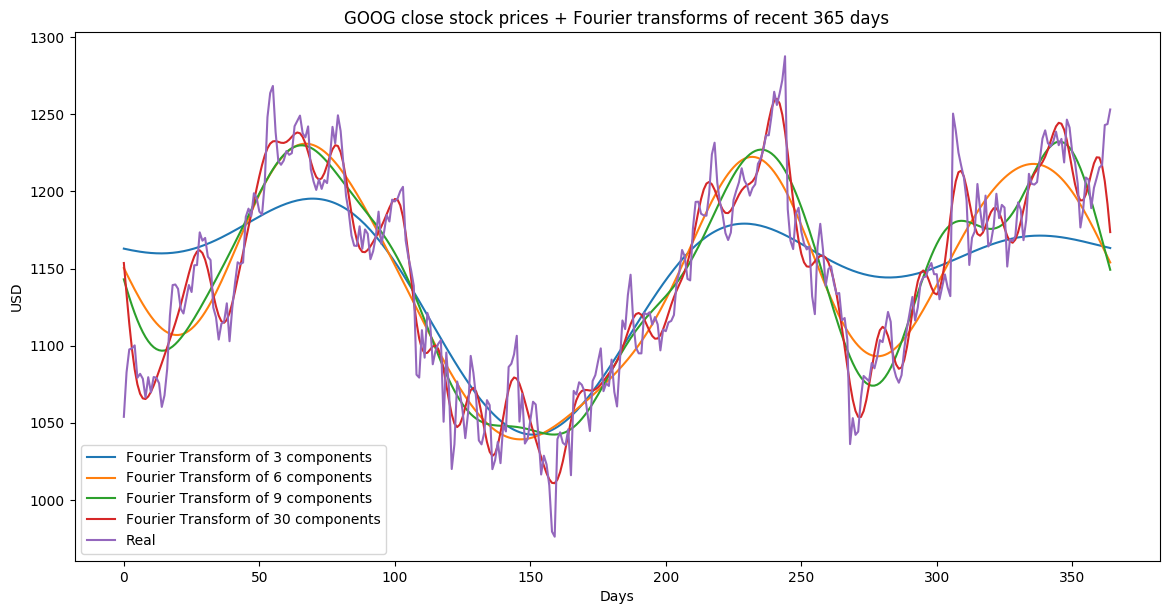

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma7,ma21,ema12,ema26,dea,macd,md,upper_band,lower_band,momentum,ema
3453,2018-05-08,1058.540039,1060.550049,1047.145020,1053.910034,1217700,0,0.0,NaN,NaN,1053.910034,1053.910034,1053.910034,0.000000,NaN,NaN,NaN,1052.910034,1053.910034
3454,2018-05-09,1058.099976,1085.439941,1056.364990,1082.760010,2032800,0,0.0,NaN,NaN,1058.348492,1056.047069,1059.680029,2.301423,NaN,NaN,NaN,1081.760010,1075.547516
3455,2018-05-10,1086.030029,1100.439941,1085.640015,1097.569946,1443000,0,0.0,NaN,NaN,1064.382562,1059.122838,1067.258013,5.259724,NaN,NaN,NaN,1096.569946,1090.793814
3456,2018-05-11,1093.599976,1101.329956,1090.910034,1098.260010,1253700,0,0.0,NaN,NaN,1069.594477,1062.021888,1073.458412,7.572589,NaN,NaN,NaN,1097.260010,1095.833496
3457,2018-05-14,1100.000000,1110.750000,1099.109985,1100.199951,1518100,0,0.0,NaN,NaN,1074.303011,1064.849893,1078.806720,9.453119,NaN,NaN,NaN,1099.199951,1098.756495


In [12]:
df = tech_indictor(df)
df = fourier_transform(df)
# df = arima_predictions(df)
df.head()

In [13]:
df["y_data"] = df.Close.shift(1)
df = df.fillna(0)
df.head()
# data = df.values
# data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma7,ma21,ema12,ema26,dea,macd,md,upper_band,lower_band,momentum,ema,y_data
3453,2018-05-08,1058.540039,1060.550049,1047.145020,1053.910034,1217700,0,0.0,0.0,0.0,1053.910034,1053.910034,1053.910034,0.000000,0.0,0.0,0.0,1052.910034,1053.910034,0.000000
3454,2018-05-09,1058.099976,1085.439941,1056.364990,1082.760010,2032800,0,0.0,0.0,0.0,1058.348492,1056.047069,1059.680029,2.301423,0.0,0.0,0.0,1081.760010,1075.547516,1053.910034
3455,2018-05-10,1086.030029,1100.439941,1085.640015,1097.569946,1443000,0,0.0,0.0,0.0,1064.382562,1059.122838,1067.258013,5.259724,0.0,0.0,0.0,1096.569946,1090.793814,1082.760010
3456,2018-05-11,1093.599976,1101.329956,1090.910034,1098.260010,1253700,0,0.0,0.0,0.0,1069.594477,1062.021888,1073.458412,7.572589,0.0,0.0,0.0,1097.260010,1095.833496,1097.569946
3457,2018-05-14,1100.000000,1110.750000,1099.109985,1100.199951,1518100,0,0.0,0.0,0.0,1074.303011,1064.849893,1078.806720,9.453119,0.0,0.0,0.0,1099.199951,1098.756495,1098.260010


In [0]:
def get_Weight(comp_tic, days):
    a = tech_indictor(df)[-days:]
    b = df[['ma7','ma21','ema12', 'ema26', 'md', 'macd','upper_band','lower_band']][-days:]
    data = b.copy()
    
    y = a['Close']
    X = data

    X_train_FI, X_test_FI, y_train_FI, y_test_FI = train_test_split(X, y, test_size=0.33, shuffle=False)

    regressor = xgb.XGBRegressor(gamma=0.0,
                                n_estimators=1500,
                                base_score=0.7,
                                colsample_bytree=1,
                                learning_rate=0.03)

    xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                            eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                            verbose=False)

    eval_result = regressor.evals_result()
    training_rounds = range(len(eval_result['validation_0']['rmse']))

    plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
    plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.title('Training Vs Validation Error')
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(8,8))
    plt.xticks(rotation='vertical')
    plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
    plt.title('Figure 6: Feature importance of the technical indicators.')
    plt.show()

In [0]:
from __future__ import print_function
#%matplotlib inline 
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from numpy import zeros, newaxis

from tqdm import tqdm

In [0]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_size, hidden_dim)  # TNC is not needed it is a specific layout to MXNet
        self.linear = nn.Linear(hidden_dim, output_size, bias=False)


    def forward(self, input):
        x, _ = self.lstm(input)
        # x = x[:, -1, :]
        x = torch.relu(x)
        x = self.linear(x)
        # x = self.softmax(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv1d(nc, 32, 1, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=False),
            
            # state size. (ndf) x 32 x 32
            nn.Conv1d(32, 64, 1, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=False),
            nn.BatchNorm1d(64, momentum=0.9, affine=False, track_running_stats=False), #affine = gamma & channels
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv1d(64, 1, 1, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=False),
            nn.BatchNorm1d(1, momentum=0.9, affine=False, track_running_stats=False), 

            nn.Linear(18, 50, bias=False),
            nn.BatchNorm1d(64, momentum=0.9, affine=False, track_running_stats=False), 
            nn.LeakyReLU(0.01, inplace=False),
            
            nn.Linear(50, 30, bias=False),
            # nn.ReLU(),
            nn.Linear(30, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        a = self.main(input)
        x = a.view(a.size(0), -1)
        return x

In [63]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

netG = Generator(18, 50, 18, 1).to(device)
print(netG)

nc = 1
ndf = 64
netD = Discriminator(1).to(device)
print(netD)

if torch.cuda.is_available():
    netG.cuda
    netD.cuda
    print("Generator and Descriminator Cuda Core is active.")

Generator(
  (lstm): LSTM(18, 50)
  (linear): Linear(in_features=50, out_features=18, bias=False)
)
Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(32, 64, kernel_size=(1,), stride=(1,), bias=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
    (5): Conv1d(64, 1, kernel_size=(1,), stride=(1,), bias=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): BatchNorm1d(1, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
    (8): Linear(in_features=18, out_features=50, bias=False)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=50, out_features=30, bias=False)
    (12): Linear(in_features=30, out_features=1, bias=False)
    (13): Sigmoid()
  )
)
Generator and Descrim

In [0]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, nc, 18, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0


# Setup Adam optimizers for both G and D
lr = 0.005
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Size of feature maps in generator
ngf = 32

# Number of training epochs
num_epochs = 5000

nz = 18

In [0]:
def show_data_shape():    
    x_data = df.drop(columns=["y_data", "Date"]).values
    print("x_data shape" + str(x_data.shape))
    # b = x_data[newaxis, :, :]
    # b.shape

    # x_data = torch.tensor(df.drop(columns=["y_data", "Date"]).values)
    # y_data = torch.tensor(df["y_data"].values)
    # x_data.shape

    y_data = df["y_data"].values
    y_data = y_data.reshape(data, -1, 1)
    # y_data = y_data[newaxis, :, :]
    print("y_data shape" + str(y_data.shape))
show_data_shape()

x_data shape(9795, 18)


ValueError: ignored

In [22]:
df.shape

(365, 20)

In [0]:
class Feature_data_loader(Dataset):

    def __init__(self):
        self.len = df.shape[0]
        self.x_data = df.drop(columns=["y_data", "Date"]).values
        self.x_data = self.x_data.reshape(365, -1, 18)
        self.x_data = torch.tensor(self.x_data)
        self.y_data = df["y_data"].values
        self.y_data = self.y_data.reshape(365, -1, 1)
        self.y_data = torch.tensor(self.y_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

dataset = Feature_data_loader()
dataloader = DataLoader(dataset=dataset, 
                        batch_size=batch_size,
                        shuffle=False, 
                        num_workers=workers)

In [40]:
for i, data in enumerate(dataloader, 0):  #没用

    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device, dtype=torch.float)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, device=device)
    # Forward pass real batch through D
    output = netD(real_cpu).view(-1)
    # Calculate loss on all-real batch
    print(output.shape)
    errD_real = criterion(output, label)

    # print(output.shape)

    # print("real_cpu shape: " + str(real_cpu.shape))
    # print("label.shape: " + str(label.shape) + "\n")

    # output = netD(real_cpu).view(-1)
    # Calculate loss on all-real batch
    # errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    # errD_real.backward()
    # D_x = output.mean().item()
    # clear_output()

torch.Size([128])
torch.Size([128])
torch.Size([109])


In [0]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch

for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device, dtype=torch.float)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 1, 18, device=device)

        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D

        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ###########################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [0]:
from numpy import zeros, newaxis
x_data = df.drop(columns=["y_data", "Date"]).values
x_data.shape
b = x_data[newaxis, :, :]
b.shape

# x_data = torch.tensor(df.drop(columns=["y_data", "Date"]).values)
# y_data = torch.tensor(df["y_data"].values)
# x_data.shape

In [0]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_size, hidden_dim) # TNC is not needed it is a specific layout to MXNet
        self.linear = nn.Linear(hidden_dim, output_size, bias=False)


    def forward(self, sentence):
        x, _ = self.lstm(x)
        # x = x[:, -1, :]
        x = self.linear(x)
        # x = self.softmax(x)
        return x


rnn = Generator(18, 64, 1)


criterion = nn.BCELoss()
  
import torch.optim as optim

# print(net.fc1.weight.requires_grad)
# print(net.fc1.bias)

optimizer = optim.Adam(rnn.parameters(), lr=0.001)

  #optimizer.zero_grad()  # zero the gradient buffers
for i in range(1000):
  optimizer.zero_grad()
  output = rnn(x_train)
  #print(output.size())
  loss = criterion(output, y_train)
  if (i%50==0): print(loss, "Train acc: %f, Test acc:%f" % (acc(x_train, y_train), acc(x_test, y_test)))
  loss.backward(retain_graph=True)
  optimizer.step()

NameError: ignored